importing Jupyter notebook from Vant_hoff_extrapolation.ipynb
UV pB of dsHCV at 60°C is 18.315%
UV pB of dsHCVm6A at 60°C is 27.178%
Stored 'on_a_fl_ss' (Variable)
Stored 'on_b_fl_ss' (Variable)
Stored 'off_a_fl_ss' (Variable)
Stored 'off_b_fl_ss' (Variable)
Stored 'tharm_ss' (float64)


Vant_hoff_extrapolation.ipynb:32: RuntimeWarning: divide by zero encountered in log
  "metadata": {},
Vant_hoff_extrapolation.ipynb:42: RuntimeWarning: divide by zero encountered in log
  "def dg_to_pB(dG, T = 65+273.15):\n",
Vant_hoff_extrapolation.ipynb:32: RuntimeWarning: divide by zero encountered in log
  "metadata": {},
Vant_hoff_extrapolation.ipynb:42: RuntimeWarning: divide by zero encountered in log
  "def dg_to_pB(dG, T = 65+273.15):\n",
/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
Vant_hoff_extrapolation.ipynb:16: RuntimeWarning: divide by zero encountered in log
  "from uncertainties import ufloat, unumpy\n",
No handles with labels found to put in legend.


Stored 'on_a_fl_ds' (Variable)
Stored 'on_b_fl_ds' (Variable)
Stored 'off_a_fl_ds' (Variable)
Stored 'off_b_fl_ds' (Variable)
Stored 'tharm_ds' (float64)


/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
Vant_hoff_extrapolation.ipynb:32: RuntimeWarning: divide by zero encountered in log
  "metadata": {},
Vant_hoff_extrapolation.ipynb:42: RuntimeWarning: divide by zero encountered in log
  "def dg_to_pB(dG, T = 65+273.15):\n",


Stored 'on_a_fl_m' (Variable)
Stored 'on_b_fl_m' (Variable)
Stored 'off_a_fl_m' (Variable)
Stored 'off_b_fl_m' (Variable)
Stored 'tharm_m' (float64)


NameError: name 'matplotlib' is not defined

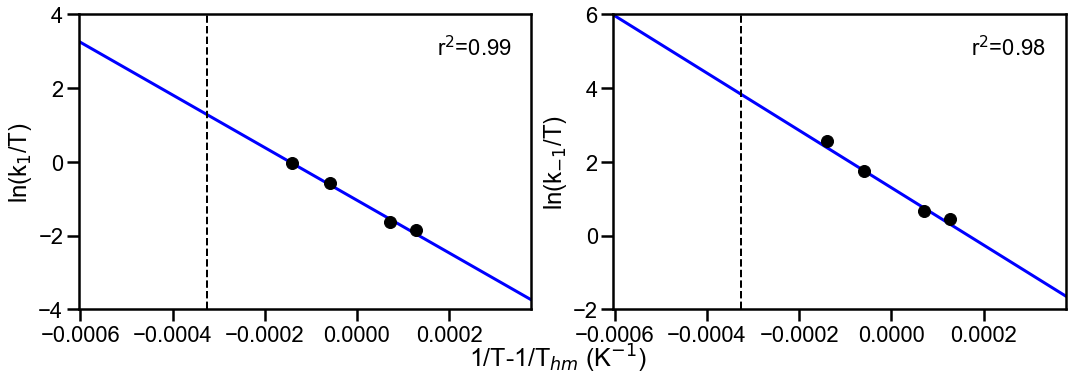

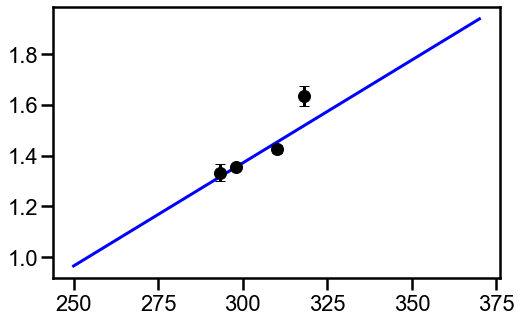

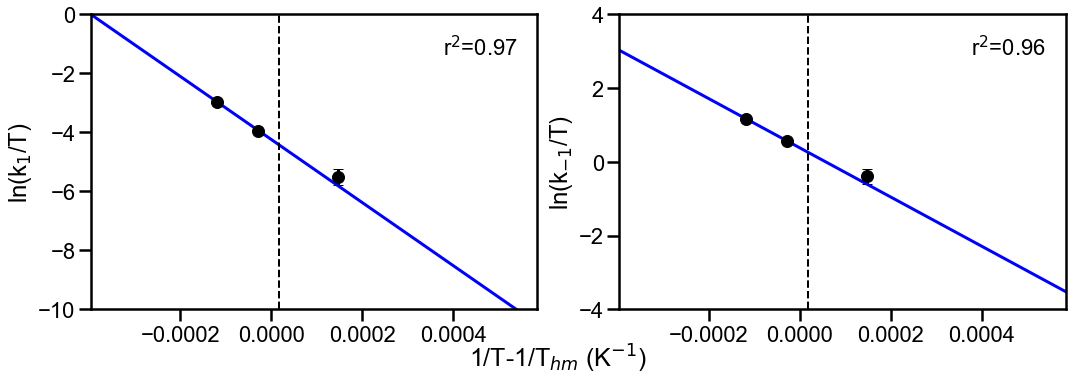

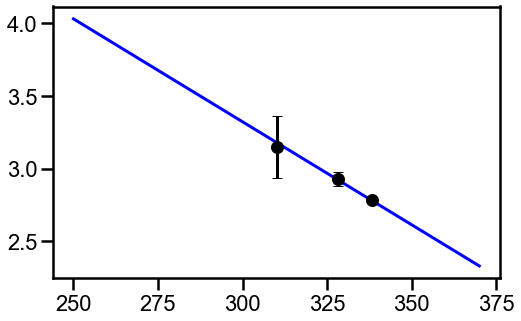

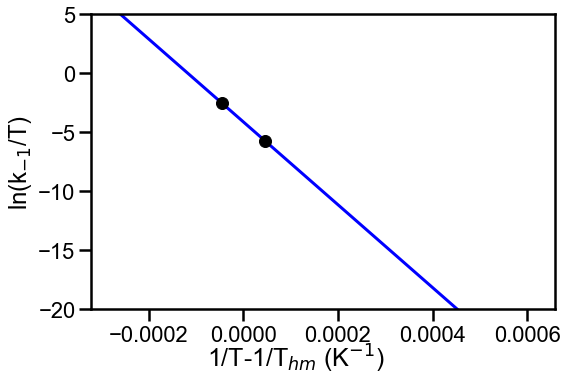

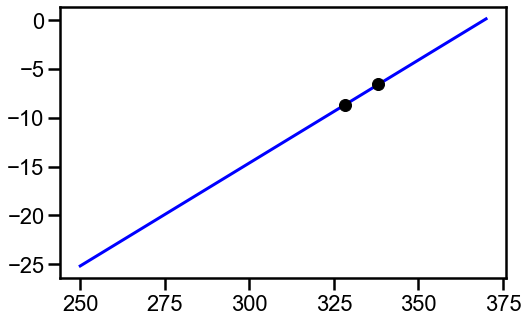

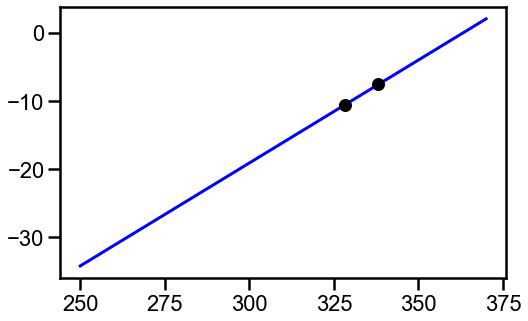

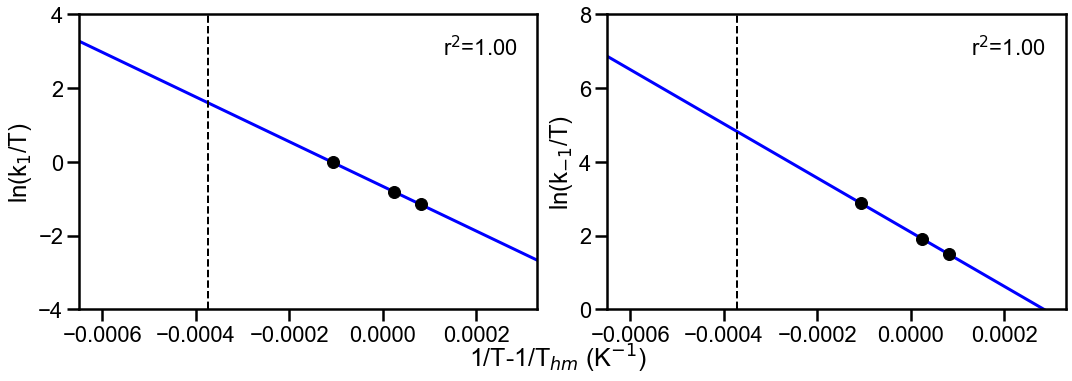

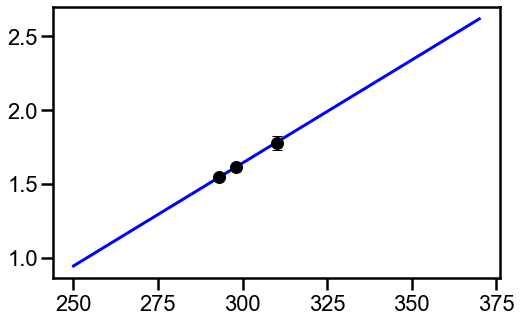

In [1]:
import numpy as np
from scipy.integrate import odeint
import import_ipynb
import Vant_hoff_extrapolation as vanhof
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit, minimize
from matplotlib import rcParams
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'Arial'
sns.set_context('poster', font_scale=1.0)
matplotlib.rcParams['legend.title_fontsize'] = 'x-large'
%matplotlib inline

In [2]:
def TAR_4_kinetic_equation(initial_c,t, *args):
    '''
    differential equation for 4-state square
    '''
    # concentrations for each molecule
    A, B, C, D = initial_c # A is the reactand, B/C are the intermediates on top right/bottom left, D is the product
    
    k1, k2, k3, k4, k5, k6, k7, k8 = args
    
    k_AB, k_BA, k_BD, k_DB, k_AC, k_CA, k_CD, k_DC = k1, k2, k3, k4, k5, k6, k7, k8
    
    dAdt = -A*(k_AC + k_AB) + B*k_BA + C*k_CA
    dBdt = -B*(k_BA + k_BD) + D*k_DB + A*k_AB
    dCdt = -C*(k_CA + k_CD) + D*k_DC + A*k_AC
    dDdt = -D*(k_DB + k_DC) + C*k_CD + B*k_BD
    
    return [dAdt, dBdt, dCdt, dDdt]

# define a exponetila equation for fitting
def ExpFit(X, a, R):
    return a*(1-np.exp(-R*X))

# function to convert pB to dG_binding
R = 0.00198588 #gas constant in kcal/mol
def dg_to_pB(dG, T = 65+273.15):
    global R
    pB = exp(-dG/(R*T))
    return pB

def k_to_dg(kon, koff, T = 65+273.15):
    global R
    dG = -R*T*log((kon/koff))
    return dG

def pB_to_dg(pb, ct, T = 65+273.15):
    global R
    dG = -R*T*log(((ct*pb)**2/(ct*(1-pb))))
    return dG

def get_koff(dG, kon, T = 37+273.15):
    return kon/(exp(dG/(-R*T)))

def get_kon(dG, koff, T = 37+273.15):
    global R
    return koff*(exp(dG/(-R*T)))

def plot_fitting(t, data, equation, params, pB, kon, koff):
    '''
    plot the numerical interagtion together with fitting curved
    t: time
    data: list, numerical integration results of dsRNA concentration
    equation: equation used for fitting
    params: fitting results from ODE
    pB, kon and koff: fitting results
    '''
    #plot for control m6A pathway3
    fig, ax = plt.subplots(1, figsize=(8,5))

    ax.scatter(t, data, s = 35, label = 'simulated data')
    ax.set_ylabel('dsRNA concentration(M)')
    ax.set_xlabel('time(s)')
    ax.set_xlim(np.min(t)-np.max(t)/50, np.max(t)*1.1)
    ax.set_ylim(np.min(data)/1.1, np.max(data)*1.1)
    ax.plot(t, equation(t, *params), 'r', label = 'fit')
#     print('###equation fitting')
#     print('ssRNA pB is {:.1%}'.format(pB))
    print('kon is {:.2f}'.format(kon))
    print('koff is {:.6f}'.format(koff))
    
 # build the model
def model_building_prep(DNA_m6A_cs_k12, DNA_m6A_cs_k21, dG_DNA_m6A_total, DNA_A_kon, DNA_A_koff, 
                       DNA_m6A_if_k12, DNA_m6A_if_k21, T, cs_fold = 1, if_fold = 20):
    '''
    get koff of hybridiztaion from CS and IF pathways
    DNA_m6A_cs_k12, DNA_m6A_cs_k21:  methyl rotation rate from RNA ssRNA methyl rotation
    dG_DNA_m6A_total: overall dG of m6A
    DNA_A_kon: kon of unmodified RNA/DNA
    DNA_m6A_if_k12, DNA_m6A_if_k21: methyl rotation rate from RNA dsRNA methyl rotation
    T: temperature in C
    '''
    # CS model building
    # free energy of the first step
    dG_DNA_cs1 = k_to_dg(DNA_m6A_cs_k12, DNA_m6A_cs_k21, T+273.15)

    # dG of the second step
    dG_DNA_cs2 = dG_DNA_m6A_total - dG_DNA_cs1

    # annealing assuming to be the same as unmodified DNA
#     DNA_m6A_cs_k43 = get_koff(dG_DNA_cs2, DNA_A_kon/cs_fold, T+273.15)
    DNA_m6A_cs_k43 = get_kon(dG_DNA_cs2, DNA_A_koff, T+273.15)

    # get if pathway rate constants
    dG_DNA_if_2 = k_to_dg(DNA_m6A_if_k12, DNA_m6A_if_k21, T+273.15)
    # assuming x-fold slower than unmodified RNA
    DNA_m6A_if_45 = DNA_A_kon/if_fold
    DNA_m6A_if_54 = get_koff(dG_DNA_m6A_total+dG_DNA_if_2, DNA_m6A_if_45, T+273.15)
    
#     DNA_m6A_if_54 = DNA_A_koff*80   
#     DNA_m6A_if_45 = get_kon(dG_DNA_m6A_total+dG_DNA_if_2, DNA_m6A_if_54, T+273.15)
    return (DNA_m6A_cs_k43, DNA_m6A_if_54)

def get_fit_result(equation, model, con, t, k, ct,  
                   p0 = [26.8/2.2e6, 2.2e6], bounds = (0, (np.inf, np.inf)), opt = 'syn'):
    '''
    simulate product concentration vs time plot, and fit to equation get kon, koff, pB
    equation: equation for fitting
    model: function, kinetic model given by differential equations
    con: list, concentration of each species in the reaction
    t: time
    k: rates of each step in the kinetic model
    ct: total concentration of duplex when duplex is 100% formed
    p0: initial guess for fitting, 1/Keq and kon
    '''
    # numerical integration
    conc_results = odeint(model, con, t, k) 
    if opt == 'syn':
        data = conc_results[:,-1]
    elif opt == 'anti':
        data = conc_results[:,-2]
    elif opt == 'both':
        data = conc_results[:,-1] + conc_results[:,-2]
    # fitting
    params, pcov = curve_fit(equation, t, data,p0 = p0, bounds = bounds)
    perr = np.sqrt(np.diag(pcov))
    
    # calculate kon, koff and pB
    c_ds = data[-1]
    pB_ss = (ct-c_ds)/ct
    kon = params[1]
    kon_err = perr[1]
#     koff = kon*(ct-c_ds)**2/c_ds
    koff = ufloat(kon, kon_err)*ufloat(params[0],perr[0])
    koff_err = koff.s
#     koff = koff.n
    kon = ufloat(params[1], perr[1])
    
    
    return pB_ss, kon, koff, params, data, conc_results, (kon_err, koff_err)

In [3]:
# get methyl rotation rates at 25C

# get parameters from van_hoff notebook
%store -r on_a_fl_ss
%store -r on_b_fl_ss
%store -r off_a_fl_ss
%store -r off_b_fl_ss
%store -r tharm_ss
%store -r on_a_fl_ds
%store -r on_b_fl_ds
%store -r off_a_fl_ds
%store -r off_b_fl_ds
%store -r tharm_ds

T = 25+273.15

k1_cs = vanhof.vanhoff_err(T, on_a_fl_ss, on_b_fl_ss, tharm_ss)
k2_cs = vanhof.vanhoff_err(T, off_a_fl_ss, off_b_fl_ss, tharm_ss)

k1_if = vanhof.vanhoff_err(T, on_a_fl_ds, on_b_fl_ds, tharm_ds)
k2_if = vanhof.vanhoff_err(T, off_a_fl_ds, off_b_fl_ds, tharm_ds)

# get wtTAR kon and koff from RD data
kex_tar = ufloat(32248, 4214)
pB_TAR = ufloat(21.9, 10)/100

k12_tar = kex_tar * pB_TAR
k21_tar = kex_tar * (1-pB_TAR)

#Monomer rate constant
kex_mono = ufloat(2124.,72)
pb_mono = ufloat(6.1,0.1)/100

k1_cs = kex_mono*pb_mono
k2_cs = kex_mono*(1-pb_mono)

# get koff from dG
k_cs_on, k_if_off = model_building_prep(k1_cs, k2_cs, k_to_dg(k12_tar, k21_tar, 25+273.15)+2 , k12_tar,k21_tar, k1_if, k2_if, 25, 1, 20)


kon is 1851.81+/-0.05
koff is 128.435737+/-0.003545
pB 1 is 93.0619%
pB 2 is 0.0029%
pB 3 is 6.0449%
pB 4 is 0.8903%


(16.4863954033501+/-0.000447886140876584,
 1835.322187997851+/-0.04986022425984573,
 1851.808583401201+/-0.05030811040072231,
 0.009611747875609714)

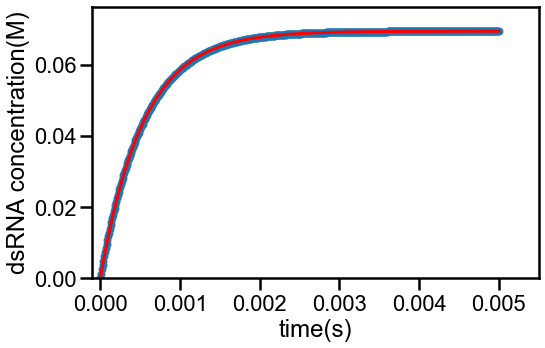

In [8]:
# Run simulation

t_A = np.linspace(0, 0.005, 500)

k_tar = (k12_tar.n/20, k_if_off.n, k2_if.n, k1_if.n, k1_cs.n, k2_cs.n, k_cs_on.n, k21_tar.n)

pB_ss, kon, koff, params, data, conc_results, err = get_fit_result(ExpFit, TAR_4_kinetic_equation, (1, 0, 0, 0), t_A,
               k_tar,1,p0=[200, 10],bounds=(0, (np.inf, np.inf)), opt='both')

plot_fitting(t_A, data, ExpFit, params, pB_ss, kon, koff)

ss_syn, ds_syn, ss_anti, ds_anti = conc_results[-1,:]

# Calculate IF Flux
cs_r1 = k1_cs.n * ss_syn
cs_r2 = (k_cs_on.n) * ds_syn
f_cs = 1/(1/cs_r1 + 1/cs_r2)

if_r1 = (k12_tar.n/20) * ss_syn
if_r2 = k2_if.n * ds_syn
f_if = 1/(1/if_r1 + 1/if_r2)

flx = f_if/(f_cs+f_if)

for j,n in enumerate(conc_results[-1,:]):
    print('pB {} is {:.4%}'.format(j+1,n))

(kon*ds_anti), kon*(1-ds_anti), kon, flx